## Trabalho Prático 1

DFT x FFT: implementar os algoritmos DFT e FFT, comparando o desempenho de ambos em sinais com um grande número de amostras.

### A Transformada Discreta de Fourier

A ideia principal desse problema é mapear n pontos no domínio do tempo para n pontos no domínio da frequência. Dado um sinal x[] de N amostras a DFT de x[] denotada por X[] é:

$$
X[k]=\sum_{n=0}^{N-1} x[n] \cdot e^{-\frac{j 2\pi k n}{N}} \space para \space k=0,1, ..., N-1.
$$
    
Uma forma mais comum de calcular a DFT é por sua forma matricial que é dada como X=Wx. Onde X[] é a DFT de x[] W é a matriz DFT e x[] é o sinal de entrada (vetor). Expandindo W podemos escrevê-la como uma matriz de Vandermonde:

$$
W = 
% \\frac{1}{\\sqrt{N}}
\begin{bmatrix}
1 & 1 & 1 & 1 & ... & 1\\
1 & w & w² & w³ & ... & w^{N-1}\\
1 & w² & w⁴ & w⁶ & ... & w^{2(N-1)}\\
1 & w³ & w⁶ & w⁹ & ... & w^{3(N-1)}\\
. & . & . & . & ... & .\\
1 & w^{N-1} & w^{2(N-1)} & w^{3(N-1)} & ... & w^{(N-1)(N-1)}\\
\end{bmatrix}
$$

Logo a DFT de x[] pode ser escrita como:

$$
X = 
% \frac{1}{\sqrt{N}}
\begin{bmatrix}
1 & 1 & 1 & 1 & ... & 1\\
1 & w & w² & w³ & ... & w^{N-1}\\
1 & w² & w⁴ & w⁶ & ... & w^{2(N-1)}\\
1 & w³ & w⁶ & w⁹ & ... & w^{3(N-1)}\\
. & . & . & . & ... & .\\
1 & w^{N-1} & w^{2(N-1)} & w^{3(N-1)} & ... & w^{(N-1)(N-1)}\\
\end{bmatrix}
\begin{bmatrix}
x_1\\
x_2\\
x_3\\
x_4\\
...\\
x_n\\
\end{bmatrix}
=
\begin{bmatrix}
X_1\\
X_2\\
X_3\\
X_4\\
...\\
X_n\\
\end{bmatrix}
$$

Sabendo que $w_{n,k}=e^{-\frac{j2\pi (nk)}{N}} \Rightarrow w = e^{-\frac{j2\pi}{N}}$.

Como vimos o cálculo da DFT basicamente é uma multiplicação de matrizes:

$$
\vec{X} = W \cdot \vec{x}
$$

Assim podemos escrever o algoritmo para DFT:

In [2]:
import numpy as np
def DFT(x):
    x = np.asarray(x, dtype=float) # transforma os sinais em array
    N = x.shape[0] # extrai o tamanho do array
    n = np.arange(N) # cria um vetor de inteiros de [0, N] 1xN 
    k = n.reshape((N, 1)) # cria um vetor coluna Nx1 [0, N]
    W = np.exp(-2j * np.pi * k * n / N) # Monta a matriz W NxN
    X = np.dot(W, x) # retorna W * x 
    return X

Podemos testar a acurácia deste algoritmo comparando com a função que a biblioteca Numpy nos fornece para calcular a DFT, pelo método de FFT:

In [3]:
x = np.random.random(1024) # Um vetor de teste com 1024 com valores (0, 1]

np.allclose(DFT(x), np.fft.fft(x))

True

Buscando uma comparação simples de desempenho, podemos analisar a proporção dos tempos de execução:

In [4]:
%timeit DFT(x)
%timeit np.fft.fft(x) 

56.9 ms ± 3.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
10.5 µs ± 63.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [5]:
import timeit

dft_time = timeit.Timer('DFT(x)', globals=globals()).timeit(number=1)
fft_time = timeit.Timer('np.fft.fft(x)', globals=globals()).timeit(number=1)

print("A proporção aproximada é fft/dft = %.6f%%" % ((fft_time / dft_time) * 100))


A proporção aproximada é fft/dft = 0.084188%


Essa proporção é esperada, dado que o nosso algoritmo `first_DFT` tem complexidade $O(N²)$ e o `np.fft` complexidade $O(n logn)$. Assim, para um vetor de entrada de comprimento $N$, o algoritmo FFT escala bem menos que o nosso algoritmo DFT.

### FFT



Primeiramente, podemos observar que W é uma matriz simétrica, e é isso que iremos usar para "diminuir" o problema da DFT. Essa propriedade decorre da matriz utilizar os índices dos elementos - linha ($n$) e coluna ($k$) - para elevar os elementos à $k \cdot n$. Assim, serao iguais todos os elementos acima e abaixo da diagonal principal $M[i,j] = M[j,i], \space para \space i \neq j$.

De forma que:


Sendo
$$
W_{N} = e^{\frac{-j2\pi}{N}} e \space W^{k}_{N} = e^{\frac{-j2 \pi k}{N}}\\
\space\\
$$
Percebe-se a simetria do conjugado complexo:
$$
W^{k(N-n)}_{N} = W^{kN}_{N} \cdot W^{-kn}_{N} = 1 \cdot W^{-kn}_{N} = W^{kn}_{N} 
$$
Além disso, temos também a periodicidade do círculo trigonométrico:
$$
W^{kn}_{N} = 1 \cdot W^{kn}_{N} = W^{kN}_{N} \cdot W^{kn}_{N} = W^{k(N + n)}_{N}
$$


Assim, podemos explorar a simetria e tal como Cooley e Tukey, dividindo a DFT em ímpares e pares:

Assumindo que N é uma potência de 2.

$$
X[k]=\sum_{n=0}^{N-1}x[n]⋅e^{\frac{−j 2\pi k n}{N}} \\
    = \sum_{m=0}^{\frac{N}{2}-1}x[2m]⋅e^{\frac{−j 2\pi k (2m)}{N}} + \sum_{m=0}^{\frac{N}{2}-1}x[2m+1]⋅e^{\frac{−j 2\pi k (2m+1)}{N}}\\
    = \sum_{m=0}^{\frac{N}{2}-1}x[2m]⋅e^{\frac{−j 2\pi k (m)}{N/2}} + e^{\frac{−j 2\pi k}{N}}\sum_{m=0}^{\frac{N}{2}-1}x[2m+1]⋅e^{\frac{−j 2\pi k m}{N/2}} 
$$

**Abusando da simetria**

Ainda podemos simplificar bem mais, contanto que nossas transformadas de Fourier menores tenham um valor par M (N/2), podemos reaplicar essa abordagem de dividir e conquistar, reduzindo pela metade o custo computacional a cada iteração, até que nossos arrays sejam pequenos o suficiente. E, no fim, chegaremos em $O[N log N]$.

E, agora, podemos ver um exemplo de implementação deste algoritmo recursivo:

In [6]:
def FFT(x):
  x = np.asarray(x, dtype=float)
  N = x.shape[0]
  
  if N % 2 > 0:
      raise ValueError("o tamanho da amostra deve ser potência de 2")
  elif N <= 32:  # Se o tamanho da amostra for menor que 33 usamos o método lento
      return DFT(x)
  else:
      X_par = FFT(x[0::2])
      X_impar = FFT(x[1::2])
      fator = np.exp(-2j * np.pi * np.arange(N) / N)
      return np.concatenate([X_par + fator[0:int(N / 2)] * X_impar,
                              X_par + fator[int(N / 2):N] * X_impar])

Verificando se ele está correto:


In [7]:
x = np.random.random(1024)
np.allclose(FFT(x), np.fft.fft(x))

True

Comparando o tempo de execução da DFT com a FFT implementada e a FFT otimizada do Numpy da biblioteca:

In [8]:
%timeit DFT(x)
%timeit FFT(x)
%timeit np.fft.fft(x) 

53.7 ms ± 3.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.37 ms ± 30.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.4 µs ± 38.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [9]:
import timeit

myfft_time = timeit.Timer('FFT(x)', globals=globals()).timeit(number=1)
fft_time = timeit.Timer('np.fft.fft(x)', globals=globals()).timeit(number=1)

print("A proporção aproximada é (np.fft)/FFT = %.6f%%" % ((fft_time / myfft_time) * 100))


A proporção aproximada é (np.fft)/FFT = 0.907446%


Percebe-se que o  FFT implementado é uma ordem de magnitude mais rápido que o DFT, todavia, ainda é muito mais lerdo que o FFT do numpy.
Para otimizar nosso FFT, podemos vetorizar computações repetidas de forma a evitar recursões de stack do python e alocação de arrays temporários

### FFT - Versão Vetorizada


Na implementação atual, no nível mais baixo de recursão, são realizadas 32 multiplicações idênticas matriz x vetor. É possível computar esses produtos como uma única multiplicação, além disso, em cada nível de recursão subsequente, é possível vetorizar operações duplicadas e diminuir a quantidade de vetores na memória.

A seguir uma implementação dessas otimizações:

In [10]:
def FFT_vetorizado(x): #não recursivo
    x = np.asarray(x, dtype=float)
    N = x.shape[0]

    if np.log2(N) % 1 > 0:
        raise ValueError("tamanho deve ser uma potência de 2")
        
    #quando o tamanho do problema for menor que 33, será realizada a DFT uma única vez
    N_min = min(N, 32)
    n = np.arange(N_min)
    k = n[:, None]
    M = np.exp(-2j * np.pi * n * k / N_min)
    X = np.dot(M, x.reshape((N_min, -1)))

    #enquanto o tamanho do problema for maior que 32, será utilizada a FFT
    while X.shape[0] < N:
        #matrizes de tamanho par
        X_par = X[0:N, 0:int(X.shape[1] / 2)]
        #matrizes de tamanho ímpar
        X_imp = X[0:N, int(X.shape[1] / 2):N]
        factor = np.exp(-1j * np.pi * np.arange(X.shape[0])
                        / X.shape[0])[:, None]
        X = np.vstack([X_par + factor * X_imp,
                       X_par - factor * X_imp])

    return X.ravel()

Verificando o resultado:

In [11]:
x = np.random.random(1024)
np.allclose(FFT_vetorizado(x), np.fft.fft(x))

True

Comparando os tempos de execução:

In [12]:
x = np.random.random(1024)

%timeit FFT(x)
%timeit FFT_vetorizado(x)
%timeit np.fft.fft(x)

2.36 ms ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
243 µs ± 495 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
10.6 µs ± 221 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Assim, podemos ver que a ordem de grandeza está bem próxima do algoritmo `np.fft`, o que era esperado devido ás otimizações.

### Testes com amostras significativas

Os testes serão divididos em dois, o primeira parte com valores pré-definidos de N, a saber, 4096, 8192 e 16384.

In [13]:
import numpy as np
import seaborn as sns

def potencias_de_2(n):
  r = []
  pot = 0
  for i in range(n):
    pot = 1<<i
    if pot > n:
      break
    else:
      r.append(pot)
  return r

#### Teste 1.1 (4096 amostras)

Gráfico de frequência do sinal de entrada:


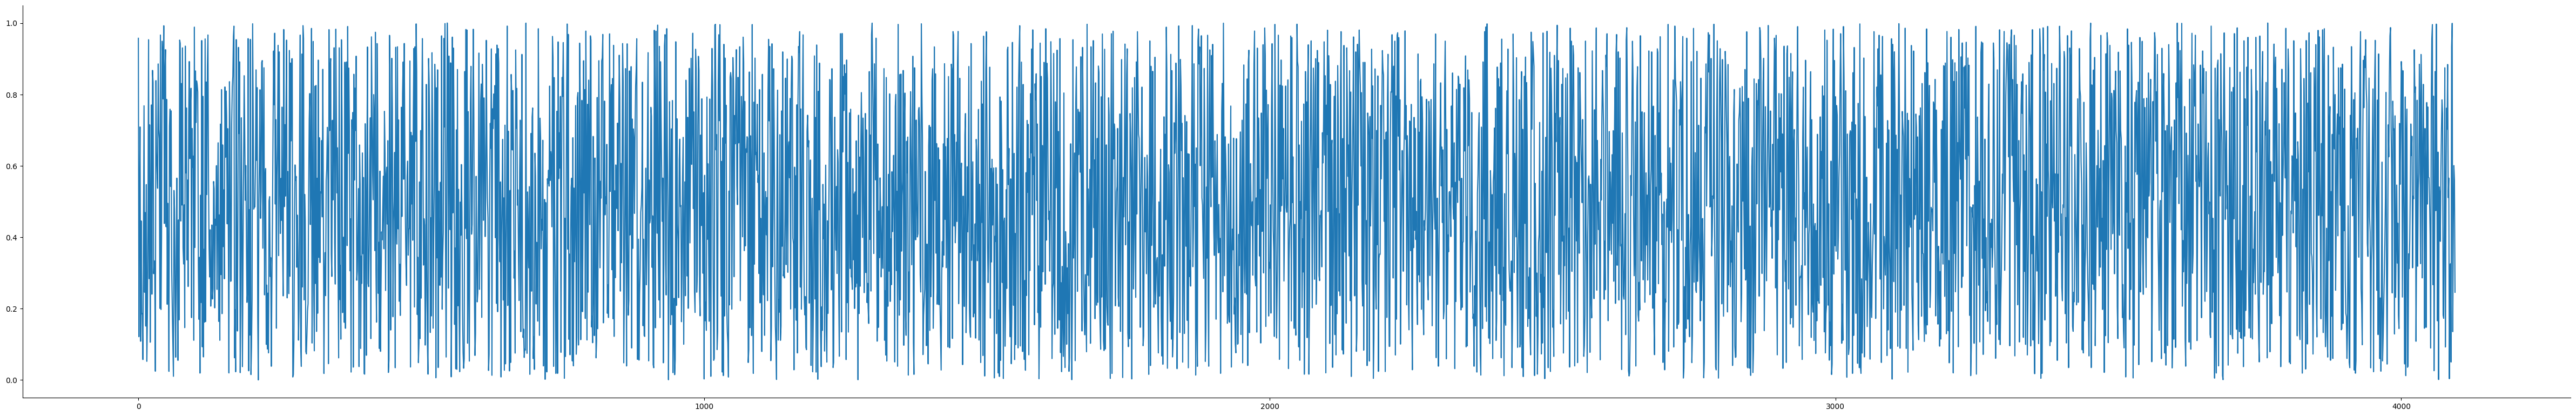

In [14]:
## 1º teste (TESTE FIXO DE 2096 AMOSTRAS)
N = 4096
x = np.random.random(N)
n = np.arange(N)

print("Gráfico de frequência do sinal de entrada:")
sns.relplot(y=x, x=n, kind="line", height=8, aspect=6)

Gráfico da magnitude dos coeficientes da FFT:


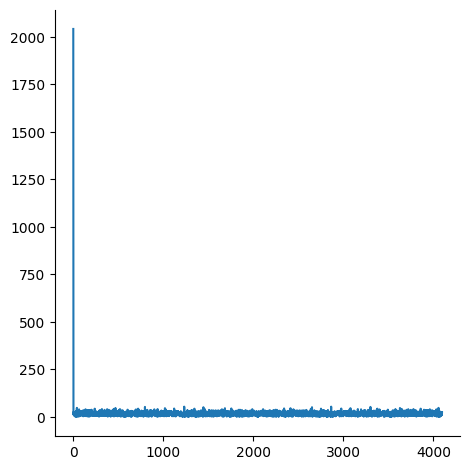

In [15]:
print("Gráfico da magnitude dos coeficientes da FFT:")
sns.relplot(y=np.abs(FFT_vetorizado(x)), x=n, kind="line")

In [16]:
print("Tamanho de amostra de %d" % N)
%timeit DFT(x)
%timeit FFT(x)
%timeit FFT_vetorizado(x)
%timeit np.fft.fft(x) 

Tamanho de amostra de 4096
670 ms ± 3.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.2 ms ± 237 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
770 µs ± 93.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
37.5 µs ± 52 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### Teste 1.2 (8192 amostras)

Gráfico de frequência do sinal de entrada:


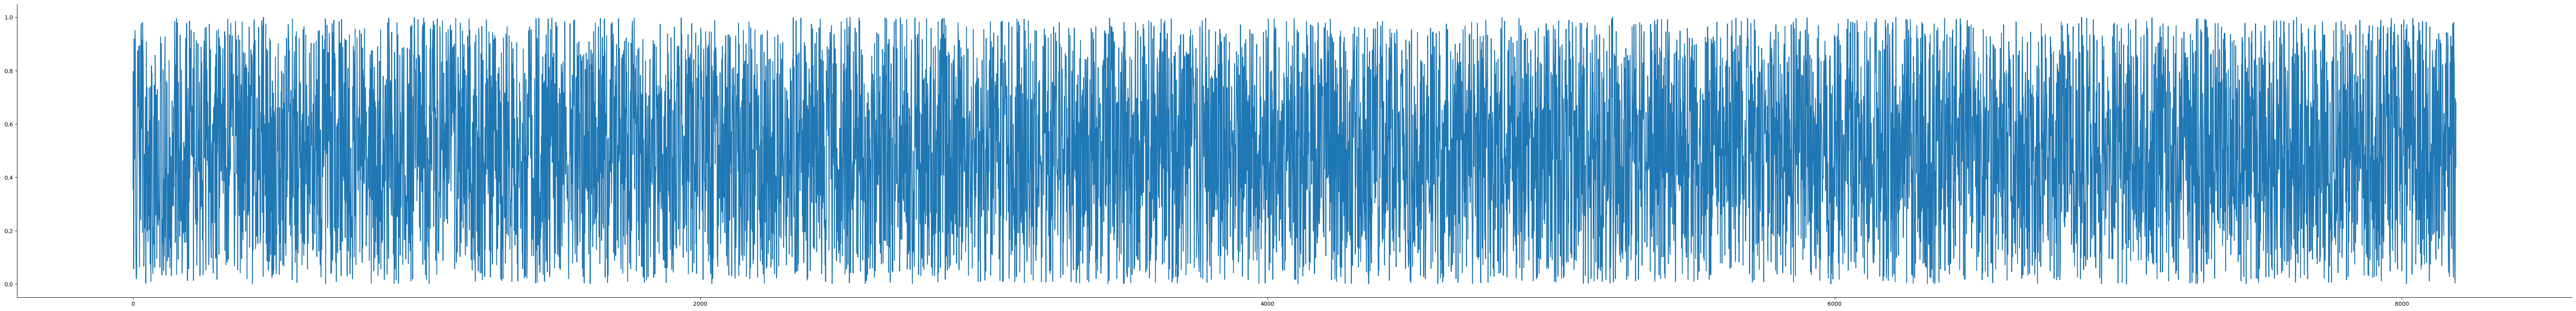

In [17]:
N = 8192
x = np.random.random(N)
n = np.arange(N)

print("Gráfico de frequência do sinal de entrada:")
sns.relplot(y=x, x=n, kind="line", height=8, aspect=8)

Gráfico da magnitude dos coeficientes da FFT:


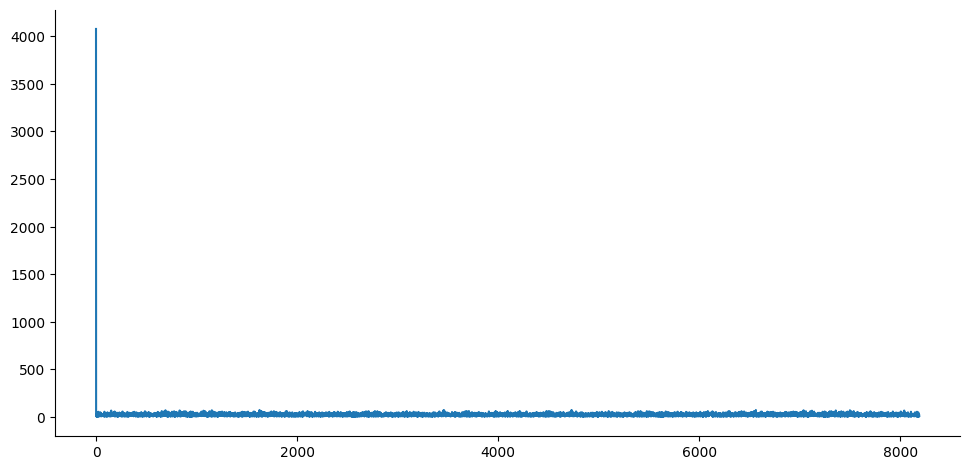

In [18]:
print("Gráfico da magnitude dos coeficientes da FFT:")
sns.relplot(y=np.abs(FFT_vetorizado(x)), x=n, kind="line", aspect=2)

In [19]:
print("Tamanho de amostra de %d" % N)
%timeit DFT(x)
%timeit FFT(x)
%timeit FFT_vetorizado(x)
%timeit np.fft.fft(x) 

Tamanho de amostra de 8192
2.63 s ± 28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
19.8 ms ± 24.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.13 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
87.2 µs ± 415 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### Teste 1.3 (16384 amostras)

Gráfico de frequência do sinal de entrada:


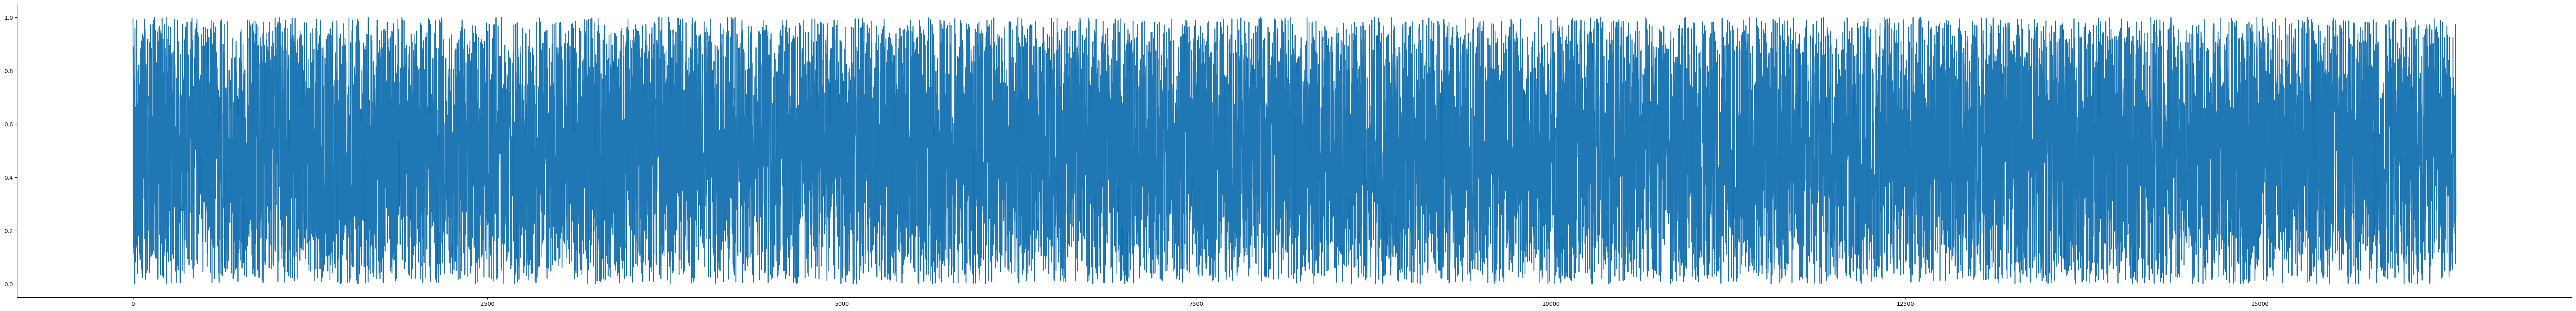

In [20]:
N = 16384
x = np.random.random(N)
n = np.arange(N)

print("Gráfico de frequência do sinal de entrada:")
sns.relplot(y=x, x=n, kind="line", height=8, aspect=8)

Gráfico da magnitude dos coeficientes da FFT:


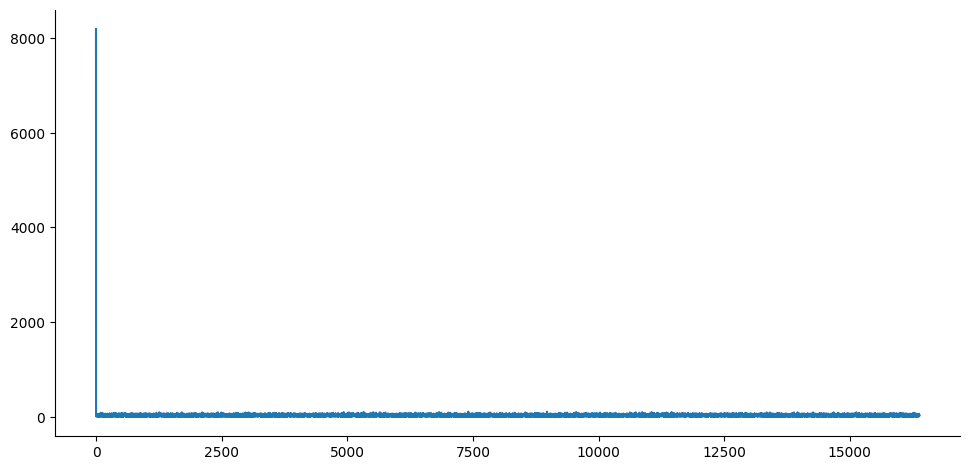

In [21]:
print("Gráfico da magnitude dos coeficientes da FFT:")
sns.relplot(y=np.abs(FFT_vetorizado(x)), x=n, kind="line", aspect=2)

In [22]:
print("Tamanho de amostra de %d" % N)
%timeit DFT(x)
%timeit FFT(x)
%timeit FFT_vetorizado(x)
%timeit np.fft.fft(x) 

Tamanho de amostra de 16384
10.9 s ± 396 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
40.9 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.41 ms ± 667 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
171 µs ± 189 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### **Testes com amostras de tamanhos aleatórios**

In [23]:
# valor aleatório entre 1024 e 3000000
r = np.random.randint(1024, 3000000)
x = np.random.random(r)
n = np.arange(r)

ehPotenciaDeDois = ((r != 0) and ((r & (r - 1)) == 0))

if ehPotenciaDeDois == False:
  new_r_list = potencias_de_2(r)
  new_r = new_r_list.pop()
  print("WARNING: O tamanho da amostra deve ser potência de 2. Usando %d para FFT()..." % new_r)
  x_fft = np.random.random(new_r)

print("Tamanho de amostra de %d" % r)
%timeit DFT(np.random.random(2048) if r > 8000 else x)
%timeit FFT(x if ehPotenciaDeDois else x_fft)
%timeit FFT_vetorizado(x if ehPotenciaDeDois else x_fft)
%timeit np.fft.fft(x) 

Tamanho de amostra de 720939
168 ms ± 484 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.42 s ± 3.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
98.9 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
197 ms ± 6.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
## Teste com input
N = input("Entre com o tamanho da amostra desejada:")
N = int(N)
x = np.random.random(int(N))
n = np.arange(N)

ehPotenciaDeDois = ((N != 0) and ((N & (N - 1)) == 0))

if ehPotenciaDeDois == False:
  new_N_list = potencias_de_2(N)
  new_N = new_N_list.pop() # extrai a potencia de 2 mais próxima de N
  print("WARNING: O tamanho da amostra deve ser potência de 2. Usando %d para FFT()..." % new_N)
  x_fft = np.random.random(new_N)

print("Tamanho de amostra de %d" % N)
%timeit DFT(x)
%timeit FFT(x if ehPotenciaDeDois else x_fft)
%timeit FFT_vetorizado(x if ehPotenciaDeDois else x_fft)
%timeit np.fft.fft(x) 

Tamanho de amostra de 2000
161 ms ± 377 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.42 ms ± 167 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
246 µs ± 4.17 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
19.7 µs ± 6.01 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
